# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "daniel"
ln1 = "wamo"
fn2 = "samuel"
ln2 = "guilhem-ducléon"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_wamo_daniel_and_guilhem-ducléon_samuel.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

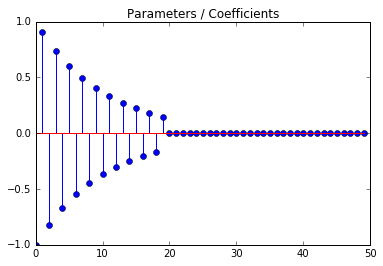

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [6]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""
    ret = np.multiply(np.sign(x), np.maximum(0, (np.absolute(x) - s*t )))
    
    return ret
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    ret = s * np.linalg.norm(x, 1)
    
    return ret

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""
    ret = 1/(1 + s*t) * x
    
    return ret

def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    ret = s * ((pow(np.linalg.norm(x, 2), 2))/2)
    
    return ret

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

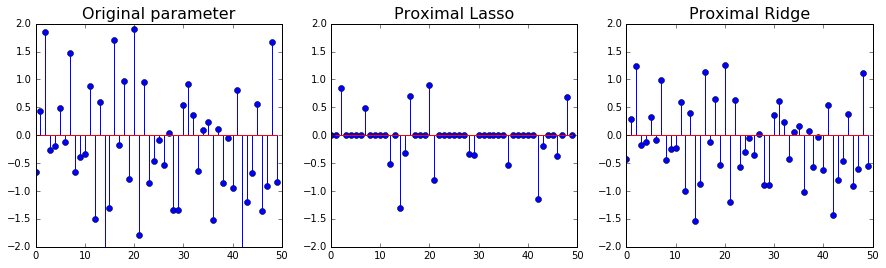

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences).

Unlike the Ridge penalization, the Lasso penalization tends to set a lot of terms to 0. Lasso penalization induces more sparsity.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [8]:
from scipy.optimize import check_grad

A, b = simu_linreg(coefs)
n = b.shape[0]

def loss_linreg(x):
    """Least-squares loss"""
    ret = 1/(2*n) * np.linalg.norm(b - A.dot(x))**2
    
    return ret

def grad_linreg(x):
    """Least-squares gradient"""
    ret = (1/n) * A.T.dot(A.dot(x) - b)
    
    return ret

print("Let's calculate the error on our gradient function for linear regression:")
check = check_grad(loss_linreg, grad_linreg, np.ones(x.shape[0]))
print("Error : %f" % check)

A, b = simu_logreg(coefs)
n = b.shape[0]

def loss_logreg(x):
    """Logistic loss"""
    ret = 0
    
    for i in range(n):
        ret += np.log(1 + np.exp(-b[i]*(A[i,:].dot(x))))
        
    ret = ret / n
        
    
    return ret

def grad_logreg(x):
    """Logistic gradient"""
    ret = 0
    
    for i in range(n):
        expo = np.exp(-b[i] * (A[i,:].dot(x)))
        
        ret += -b[i] * A[i,:] * expo / (1 + expo)
        
    ret = ret / n
    
    return ret


print("Let's calculate the error on our gradient function for logistic regression:")
check = check_grad(loss_logreg, grad_logreg, x)
print("Error : %f" % check)


Let's calculate the error on our gradient function for linear regression:
Error : 0.000006
Let's calculate the error on our gradient function for logistic regression:
Error : 0.000002


The error computed with check_grad is acceptable.

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [103]:
from numpy.linalg import norm

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""  
    n = A.shape[0]
    
    w, _ = np.linalg.eig(A.T.dot(A))
    L = np.amax(w) / n
    
    return L
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    n = A.shape[0]
    
    w, _ = np.linalg.eig(A.T.dot(A))
    L = np.amax(w) / (4*n)
    
    return L
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x = prox_g(x - step * grad_f(x) , s, step)
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [10]:
import math

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_g(z - step * grad_f(z), s, step)
        
        t_new = (1 + math.sqrt(1 + 4 * pow(t,2)))/2
        z = x_new + ((t - 1)/t_new) * (x_new - x)
        
        t = t_new
        x = x_new

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [55]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters given above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

We compute a minimum and a minimizer using FISTA for a linear regression problem with a ridge penalization. There is no need for 1000 iterations, the convergence is much faster.

In [56]:
A, b = simu_linreg(coefs)
n = b.shape[0]

n_iter=100

f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge
step = 1/(lip_linreg(A))
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter)

print(x_fista)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.28e+00 | 8.74e-01
      10 | 5.21e-01 | 1.20e-01
      20 | 5.20e-01 | 1.18e-01
      30 | 5.20e-01 | 1.17e-01
      40 | 5.20e-01 | 1.17e-01
      50 | 5.20e-01 | 1.17e-01
      60 | 5.20e-01 | 1.17e-01
      70 | 5.20e-01 | 1.17e-01
      80 | 5.20e-01 | 1.17e-01
      90 | 5.20e-01 | 1.17e-01
     100 | 5.20e-01 | 1.17e-01
[ -9.69e-01   8.90e-01  -8.01e-01   7.14e-01  -6.21e-01   5.44e-01
  -5.32e-01   4.76e-01  -4.04e-01   3.85e-01  -3.96e-01   3.09e-01
  -3.05e-01   3.12e-01  -1.84e-01   1.41e-01  -2.21e-01   1.56e-01
  -1.18e-01   1.12e-01   7.22e-02  -7.90e-02  -5.15e-03   2.54e-04
   7.02e-03   7.92e-02  -3.27e-02  -4.63e-02   1.37e-02  -1.41e-02
  -1.18e-02   2.33e-04  -1.53e-02   2.84e-03   3.88e-02  -3.50e-02
   1.49e-02  -8.83e-02   8.18e-03  -4.19e-02   1.72e-02  -1.71e-03
  -2.10e-02   4.88e-02   2.95e-02   4.95e-02  -5.04e-02  -1.71e-02
   1.66e-02   1.88e-02]


We see that less than 40 iterations are required for convergence using FISTA: to get the number of iterations needed for convergence, we just need to find out since when the error is stable.

Let's compare now with the ISTA algorithm.

In [57]:
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter)
print(x_ista)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.28e+00 | 8.74e-01
      10 | 5.74e-01 | 2.98e-01
      20 | 5.25e-01 | 1.61e-01
      30 | 5.20e-01 | 1.29e-01
      40 | 5.20e-01 | 1.21e-01
      50 | 5.20e-01 | 1.19e-01
      60 | 5.20e-01 | 1.18e-01
      70 | 5.20e-01 | 1.17e-01
      80 | 5.20e-01 | 1.17e-01
      90 | 5.20e-01 | 1.17e-01
     100 | 5.20e-01 | 1.17e-01
[ -9.69e-01   8.90e-01  -8.01e-01   7.14e-01  -6.21e-01   5.44e-01
  -5.32e-01   4.76e-01  -4.04e-01   3.85e-01  -3.96e-01   3.09e-01
  -3.05e-01   3.12e-01  -1.84e-01   1.41e-01  -2.21e-01   1.56e-01
  -1.18e-01   1.12e-01   7.22e-02  -7.90e-02  -5.15e-03   2.61e-04
   7.02e-03   7.92e-02  -3.28e-02  -4.63e-02   1.37e-02  -1.41e-02
  -1.19e-02   2.54e-04  -1.53e-02   2.84e-03   3.88e-02  -3.50e-02
   1.49e-02  -8.83e-02   8.19e-03  -4.19e-02   1.72e-02  -1.72e-03
  -2.10e-02   4.88e-02   2.95e-02   4.95e-02  -5.04e-02  -1.71e-02
   1.66e-02   1.88e-02]


The convergence is slower as it needs more than 50 iterations to converge.

Fortunately, both algorithms find (roughly) the same minimum.

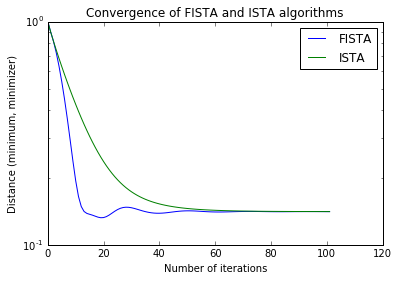

Minimum error FISTA: 0.140817
Minimum error ISTA: 0.140881


In [100]:
import matplotlib.pyplot as plt

def plot_optim(errors_fista, errors_ista, n_iter, title='Convergence of FISTA and ISTA algorithms'):
    x = np.arange(n_iter + 2)
    y_fista = errors_fista
    y_ista = errors_ista

    plt.plot(x, y_fista, 'b')
    plt.plot(x, y_ista, 'g')
    plt.yscale('log')
    plt.legend(['FISTA', 'ISTA'])
    plt.title(title)
    plt.xlabel('Number of iterations')
    plt.ylabel('Distance (minimum, minimizer)')
    plt.show()
    
    print("Minimum error FISTA: %f" % errors_fista[100])
    print("Minimum error ISTA: %f" % errors_ista[100])
    
plot_optim(errors_fista, errors_ista, n_iter)

Above is the plot of the distance between the minimizer and the true minimum in function to the number of iterations.

The convergence for the ISTA curve is in $O(\frac{1}{k})$.

The convergence for the FISTA curve is in $O(\frac{1}{k^2})$.

The FISTA algorithm is faster to converge.

**Questions**

- Question: In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

Let's compare performance of the algorithms for the linear regression with a high correlation of the features then with a low correlation of the features.

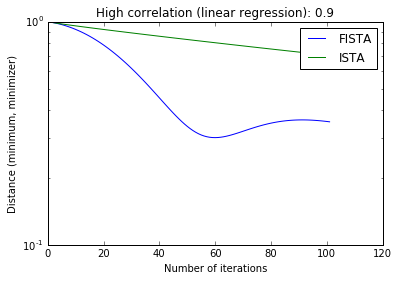

Minimum error FISTA: 0.356899
Minimum error ISTA: 0.707782


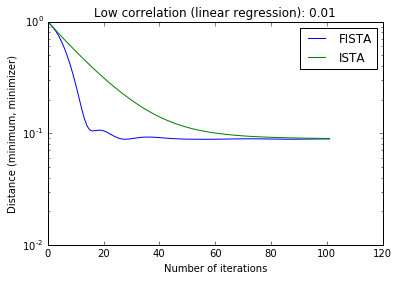

Minimum error FISTA: 0.088853
Minimum error ISTA: 0.089771


In [123]:
A, b = simu_linreg(coefs, corr=0.9)
n = b.shape[0]

x0 = np.zeros(n_features)
s = 1e-3
n_iter=100

f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge
step = 1/(lip_linreg(A))
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="High correlation (linear regression): 0.9")

A, b = simu_linreg(coefs, corr=0.01)

x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="Low correlation (linear regression): 0.01")

The larger the correlation rate, the longer it takes for both optimization algorithms to converge.

We can do the same with the logistic regression and it will leads to the same conclusion.

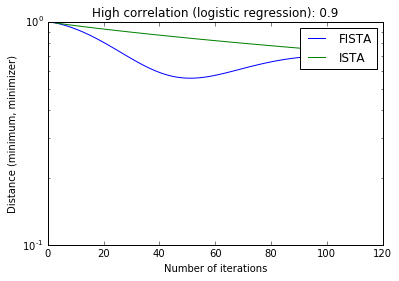

Minimum error FISTA: 0.702374
Minimum error ISTA: 0.743255


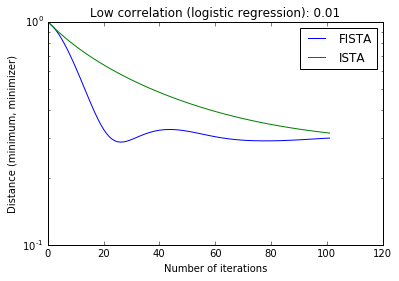

Minimum error FISTA: 0.300294
Minimum error ISTA: 0.317719


In [125]:
A, b = simu_logreg(coefs, corr=0.9)
n = b.shape[0]

x0 = np.zeros(n_features)
s = 1e-3
n_iter=100

f = loss_logreg
grad_f = grad_logreg
g = ridge
prox_g = prox_ridge
step = 1/(lip_logreg(A))
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="High correlation (logistic regression): 0.9")

A, b = simu_logreg(coefs, corr=0.01)

x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="Low correlation (logistic regression): 0.01")

- Question: In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

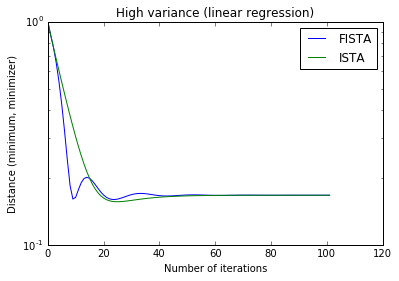

Minimum error FISTA: 0.166763
Minimum error ISTA: 0.166778


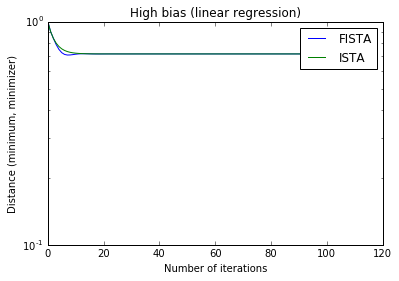

Minimum error FISTA: 0.716415
Minimum error ISTA: 0.716415


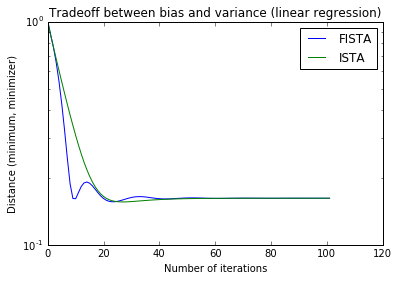

Minimum error FISTA: 0.161671
Minimum error ISTA: 0.161688


In [126]:
A, b = simu_linreg(coefs)
n = b.shape[0]

x0 = np.zeros(n_features)
s = 0
n_iter=100

f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge
step = 1/(lip_linreg(A))
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="High variance (linear regression)")

s = 1
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, "High bias (linear regression)")

s = 5e-3
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, "Tradeoff between bias and variance (linear regression)")

We see that the level of ridge penalization allow us to control the tradeoff between bias and variance we want and thus it has an influence on the found minimum.

If this level is too large, the bias will be too important and the optimization algorithms will not find a good minimizer.

If this level is too small, the variance will be too important and the optimization algorithms will not find a good minimizer.

We need to find a tradeoff between bias and variance. The appropriate level of ridge penalization could be determined using cross-validation.

If we do the same for logistic regression, we end up with the same conclusion.

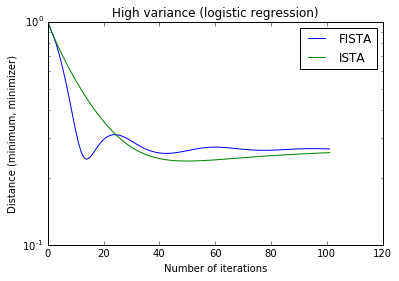

Minimum error FISTA: 0.269013
Minimum error ISTA: 0.258408


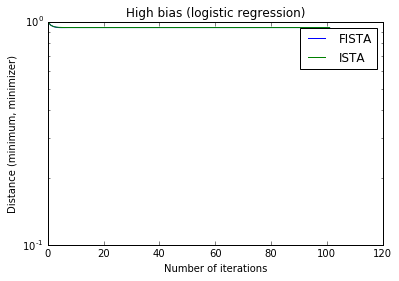

Minimum error FISTA: 0.940466
Minimum error ISTA: 0.940466


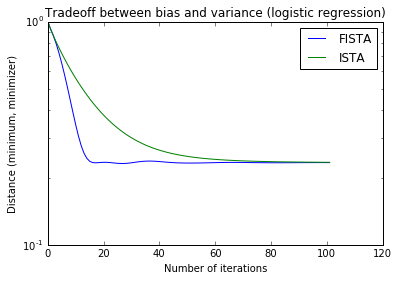

Minimum error FISTA: 0.233499
Minimum error ISTA: 0.234224


In [127]:
A, b = simu_logreg(coefs)
n = b.shape[0]

x0 = np.zeros(n_features)
s = 0
n_iter=100

f = loss_logreg
grad_f = grad_logreg
g = ridge
prox_g = prox_ridge
step = 1/(lip_logreg(A))
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="High variance (logistic regression)")

s = 1
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, "High bias (logistic regression)")

s = 5e-3
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, "Tradeoff between bias and variance (logistic regression)")

- Question: In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

For logistic regression, let's compare the ridge and lasso penalization.

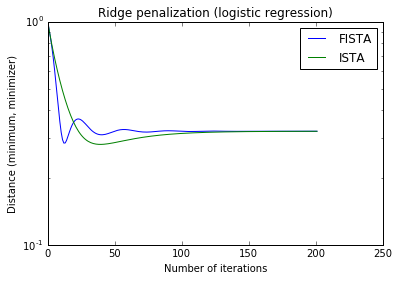

Minimum error FISTA: 0.322519
Minimum error ISTA: 0.315519
Calculation time: 5.652752 seconds


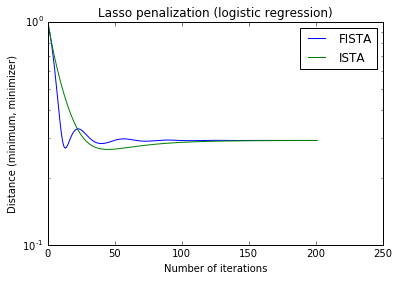

Minimum error FISTA: 0.293195
Minimum error ISTA: 0.287767
Calculation time: 6.429920 seconds


In [128]:
import time

A, b = simu_logreg(coefs)
n = b.shape[0]

x0 = np.zeros(n_features)
s = 1e-3
n_iter=200

f = loss_logreg
grad_f = grad_logreg
g = ridge
prox_g = prox_ridge
step = 1/(lip_logreg(A))

t = time.time()
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="Ridge penalization (logistic regression)")

print("Calculation time: %f seconds" % (time.time() - t))

g = lasso
prox_g = prox_lasso
t = time.time()
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="Lasso penalization (logistic regression)")

print("Calculation time: %f seconds" % (time.time() - t))

Lasso penalization is slightly faster in terms of performance and finds a better minimizer.

We can do the same with linear regression and end up with the same conclusion.

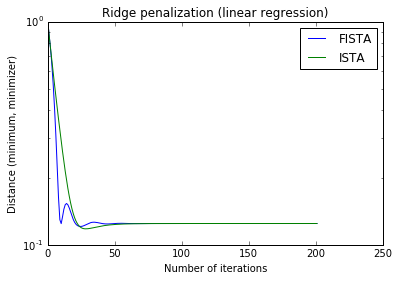

Minimum error FISTA: 0.124572
Minimum error ISTA: 0.124563
Calculation time: 0.354188 seconds


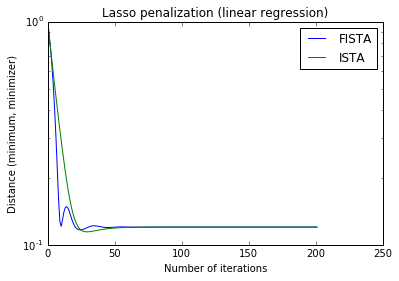

Minimum error FISTA: 0.120102
Minimum error ISTA: 0.120093
Calculation time: 0.300789 seconds


In [130]:
import time

A, b = simu_linreg(coefs)
n = b.shape[0]

x0 = np.zeros(n_features)
s = 1e-3
n_iter=200

f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge
step = 1/(lip_linreg(A))

t = time.time()
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="Ridge penalization (linear regression)")

print("Calculation time: %f seconds" % (time.time() - t))

g = lasso
prox_g = prox_lasso
t = time.time()
x_fista, objectives_fista, errors_fista = fista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)
x_ista, objectives_ista, errors_ista = ista(x0, f, grad_f, g, prox_g, step, s, n_iter, verbose=False)

plot_optim(errors_fista, errors_ista, n_iter, title="Lasso penalization (linear regression)")

print("Calculation time: %f seconds" % (time.time() - t))